# 🚘 Capítulo 1 - Introducción a la Detección de Anomalías en archivos MDF

Antes de entrar en la parte técnica del proyecto, es importante contextualizar el propósito y el origen de los datos utilizados.

El objetivo general consiste en aplicar **técnicas de detección de anomalías no supervisadas** sobre datos extraídos de archivos **MDF (Measurement Data Format)**, sin contar con etiquetas fiables ni retroalimentación de expertos o responsables del sistema de origen. Por tanto, todo el trabajo se basa en una definición genérica y fundamental de anomalía:

> **Una anomalía es una situación que se desvía significativamente del comportamiento esperado.**

Los archivos MDF utilizados provienen del **rodaje de un vehículo prototipo que aún no ha salido al mercado**. Hasta ahora, los expertos del dominio han trabajado con este tipo de datos de forma parcial, apoyándose en reglas conocidas de antemano: por ejemplo, si tras un impacto no se activa el airbag ni los intermitentes, se considera una anomalía evidente. Sin embargo, este enfoque se limita a **situaciones esperadas o visibles**, dejando fuera una gran variedad de comportamientos inesperados que podrían ser igual o más críticos, pero difíciles de anticipar.

Aquí es donde se enmarca este proyecto: como una **fase inicial exploratoria**, en la que se pretende evaluar el potencial real de aplicar algoritmos no supervisados a este tipo de señales, sin asumir conocimiento previo de los eventos. 

---

## 💡 Consideraciones sobre el enfoque

Este trabajo forma parte de un proyecto más amplio, pero debe entenderse dentro de **un contexto de recursos limitados y sin un presupuesto formal asignado** por el momento. Por tanto, el objetivo actual no es construir una solución definitiva ni exhaustiva, sino **validar una idea base y demostrar su valor potencial con el menor esfuerzo razonable**.

En resumen, esta etapa inicial busca sentar unas bases sólidas, plantear una metodología sensata y generar resultados claros que, si resultan prometedores, puedan justificar una siguiente fase con más profundidad, colaboración directa con expertos y un marco de trabajo profesional.

---

## 📚 En este primer capítulo

En este capítulo se presentarán los **fundamentos teóricos básicos** que permitirán entender qué se considera una anomalía desde un punto de vista estadístico y computacional. También se incluirán **representaciones gráficas sencillas** que ilustran cómo pueden detectarse estas desviaciones en el espacio de características.

Todo ello servirá como punto de partida para las siguientes etapas del trabajo, en las que se aplicarán y evaluarán distintas estrategias de detección sobre señales reales extraídas de archivos MDF.


---

## 📈 Anomalías en series temporales

Según **Chandola et al. (2009)**, una anomalía en una serie temporal es un **punto, subsecuencia o patrón que no se ajusta al comportamiento esperado del resto de la secuencia**. Las series temporales presentan una dificultad añadida frente a otras formas de datos, debido a que el tiempo impone una estructura secuencial: los valores consecutivos están correlacionados y condicionados por patrones como tendencia, estacionalidad o ruido.

### 🔍 Tipos de anomalías en series temporales

Es común clasificar las anomalías temporales en tres grandes categorías:

1. **Anomalía puntual (_Point anomaly_)**  
   Un único punto que se desvía significativamente del comportamiento general.  
   *Ejemplo:* Un pico de temperatura aislado.

2. **Anomalía contextual (_Contextual anomaly_)**  
   El valor parece normal en general, pero no lo es considerando su contexto.  
   *Ejemplo:* 25 °C en verano es normal; en invierno podría ser anómalo.

3. **Anomalía colectiva (_Collective anomaly_)**  
   Un grupo de valores que en conjunto forman un patrón anómalo, aunque individualmente no lo parezcan.  
   *Ejemplo:* Un descenso sostenido en la presión de un sistema.

### 📊 Ejemplos ilustrativos (en la siguiente celda de código)

A continuación se mostrarán visualizaciones sintéticas que ilustran estos tres tipos de anomalías. La idea es proporcionar una primera intuición visual sobre cómo se manifiestan distintos tipos de desviaciones cuando se observa una serie temporal.


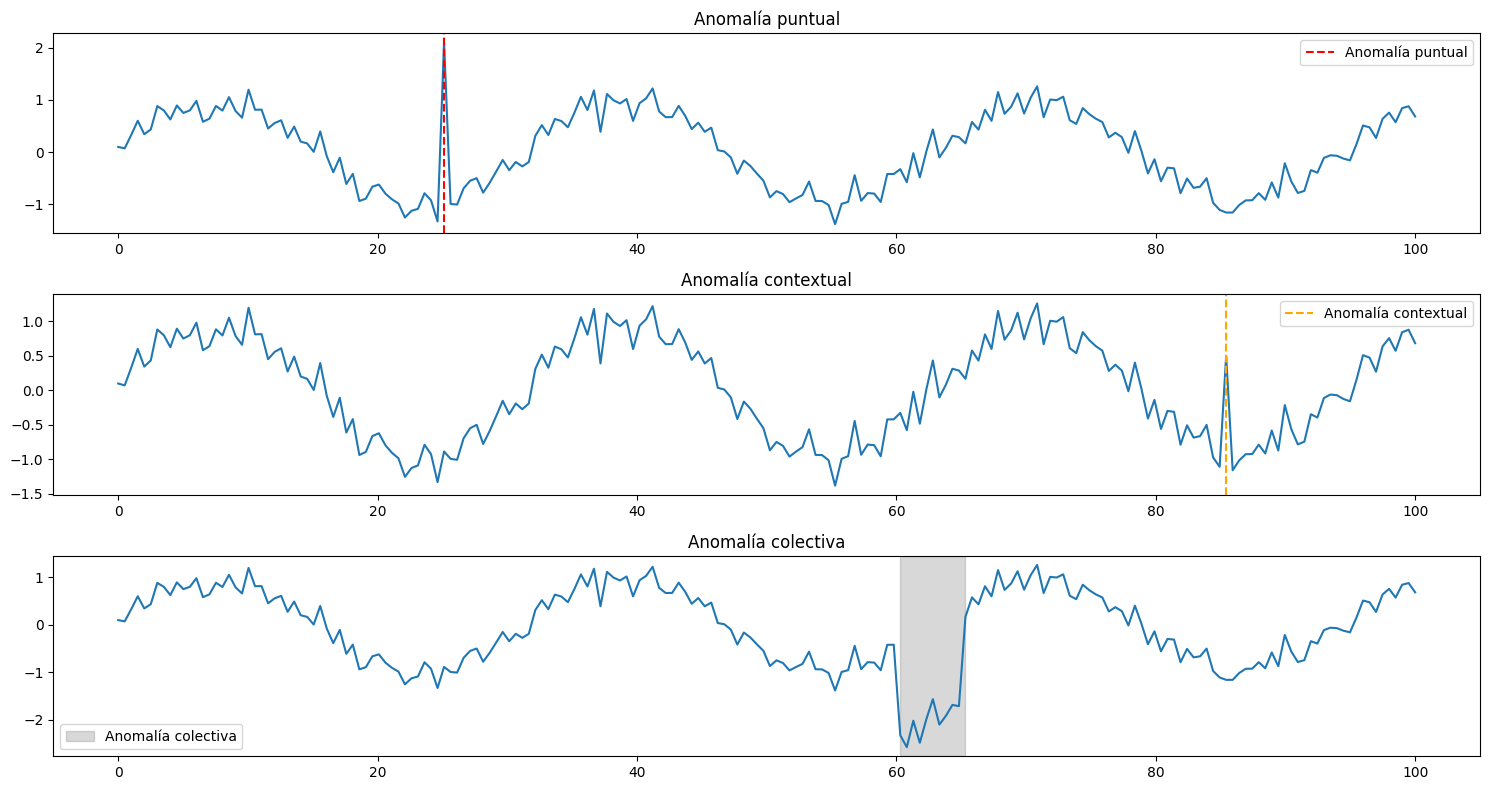

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Serie base con estacionalidad
t = np.linspace(0, 100, 200)
seasonal = np.sin(t * 0.2)  # patrón estacional
noise = np.random.normal(0, 0.2, len(t))
serie = seasonal + noise

# Anomalía puntual
serie_punto = serie.copy()
serie_punto[50] += 3

# Anomalía contextual mejorada: valor alto en un valle estacional
serie_contextual = serie.copy()
serie_contextual[170] = 0.5  # alta en un momento de baja esperada

# Anomalía colectiva
serie_colectiva = serie.copy()
serie_colectiva[120:130] -= 2

# Graficar
plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.title("Anomalía puntual")
plt.plot(t, serie_punto)
plt.axvline(t[50], color="red", linestyle="--", label="Anomalía puntual")
plt.legend()

plt.subplot(3, 1, 2)
plt.title("Anomalía contextual")
plt.plot(t, serie_contextual)
plt.axvline(t[170], color="orange", linestyle="--", label="Anomalía contextual")
plt.legend()

plt.subplot(3, 1, 3)
plt.title("Anomalía colectiva")
plt.plot(t, serie_colectiva)
plt.axvspan(t[120], t[130], color="gray", alpha=0.3, label="Anomalía colectiva")
plt.legend()

plt.tight_layout()
plt.show()


## 🧠 Componentes de una señal temporal

Desde un punto de vista clásico, una señal temporal puede descomponerse en varios componentes fundamentales:

- **Tendencia (Trend):** refleja cambios a largo plazo en el valor medio de la señal.
- **Estacionalidad (Seasonality):** patrones que se repiten de forma regular en el tiempo (por ejemplo, cada hora, cada día).
- **Ruido (Noise):** fluctuaciones aleatorias sin estructura aparente.
- **Eventos transitorios:** desviaciones breves y localizadas que alteran momentáneamente el patrón general.

Esta descomposición permite analizar por separado las distintas fuentes de variación de una señal y es ampliamente utilizada en contextos como predicción de demanda, meteorología, procesos industriales o análisis financiero.


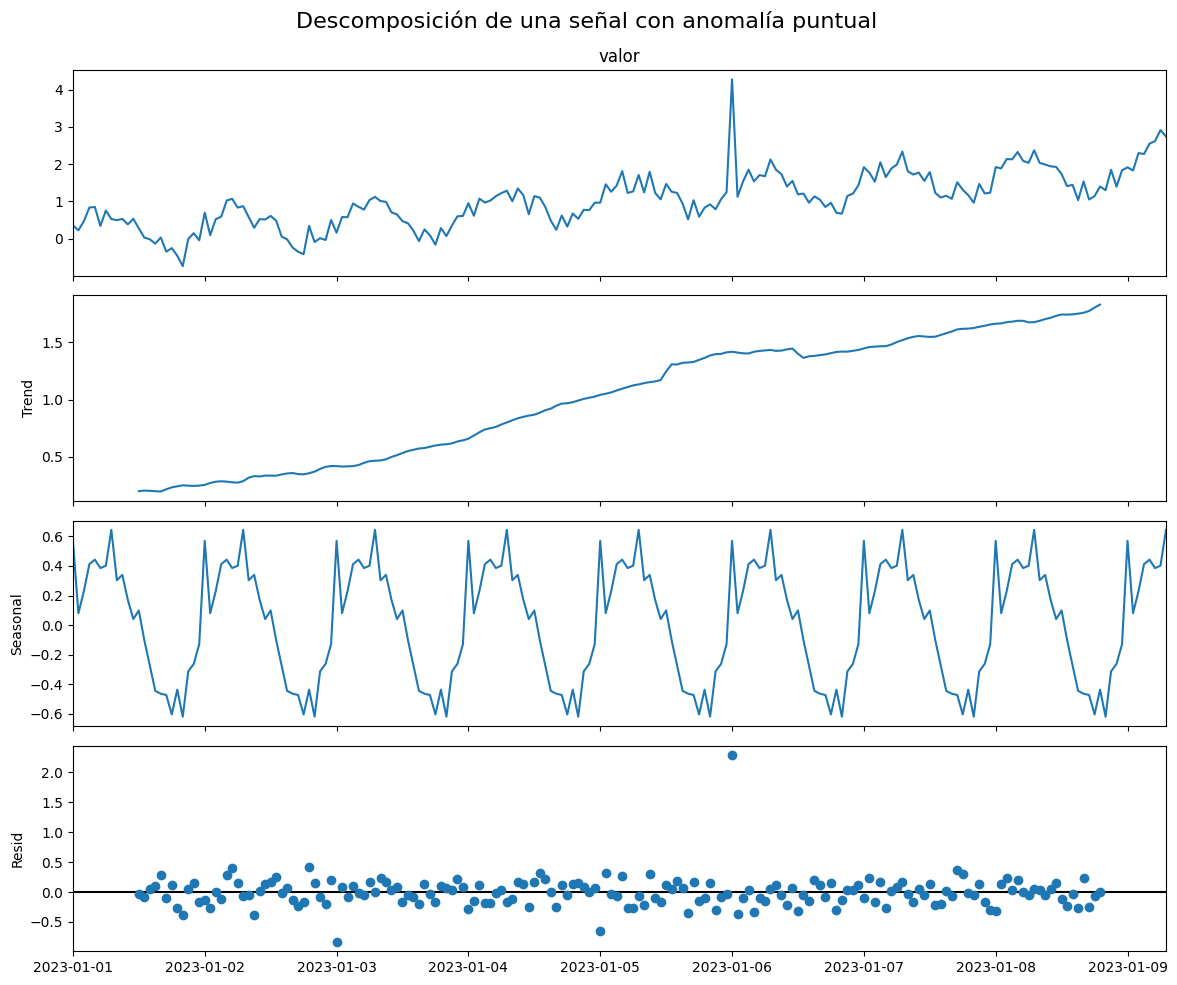

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

# Simulación de una señal con tendencia, estacionalidad y ruido
np.random.seed(0)
t = np.arange(200)
tendencia = 0.01 * t
estacionalidad = 0.5 * np.sin(2 * np.pi * t / 24)
ruido = np.random.normal(0, 0.2, size=len(t))
serie = tendencia + estacionalidad + ruido

# Introducir una anomalía clara en el punto 120
serie[120] += 3  # pico anómalo

# Convertir a serie temporal con índice horario
serie_df = pd.DataFrame({'valor': serie}, index=pd.date_range("2023-01-01", periods=len(t), freq="h"))

# Aplicar descomposición estacional (modelo aditivo, con periodo diario simulado)
descomp = seasonal_decompose(serie_df['valor'], model='additive', period=24)

# Crear figura más grande y mostrar
fig = descomp.plot()
fig.set_size_inches(12, 10)
plt.suptitle("Descomposición de una señal con anomalía puntual", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()




## 📉 Uso típico de la descomposición para detectar anomalías

Una de las aplicaciones más comunes de la descomposición de series temporales es la **detección de anomalías a través del análisis del residuo**.

El razonamiento es el siguiente:

1. Se descompone la señal en sus componentes: tendencia, estacionalidad y residuo.
2. Si la señal se comporta como se espera (es decir, sigue su tendencia y estacionalidad habituales), entonces el **residuo debería comportarse como ruido aleatorio sin estructura ni valores extremos**.
3. Por tanto, cualquier **valor atípico o pico en el residuo** puede interpretarse como una posible **anomalía**.

Este enfoque puede automatizarse combinando la descomposición con técnicas estadísticas (por ejemplo, detección de outliers con desviación estándar o IQR) o con modelos de aprendizaje automático aplicados directamente al residuo.

---

## 🎯 ¿Es útil esta descomposición para nuestras señales?

Conocer esta descomposición es útil para comprender cómo se estructura una serie temporal y qué tipo de variaciones pueden aparecer en distintos contextos. Sin embargo, **en el caso de las señales extraídas de sensores del vehículo**, su aplicabilidad es muy limitada.

- Aunque algunas señales presentan **patrones repetitivos muy breves** (por ejemplo, cambios de estado como `0 → 1 → 2` que se repiten en milisegundos),  
- La mayoría **no tienen una estacionalidad clara ni una tendencia significativa**.  
- Además, el comportamiento depende en gran medida de las condiciones dinámicas del sistema en tiempo real, no de un patrón repetitivo global.

Por tanto, aunque es interesante conocer esta teoría, **no consideramos que aplicar descomposición clásica aporte valor práctico en este proyecto**.

El análisis de anomalías se abordará desde una perspectiva más flexible, utilizando técnicas que se adapten mejor a la naturaleza de las señales. Entre ellas:

- **Modelos basados en rareza estadística**, como *Isolation Forests*, que son eficaces para detectar **valores atípicos en espacios de características multivariadas**, sin asumir ninguna estructura temporal.
- **Modelos que aprenden patrones de comportamiento secuencial o contextual**, como *Modelos Ocultos de Markov (HMM)* o *Autoencoders*, que permiten identificar **rupturas en la dinámica habitual** aunque los valores individuales no sean extremos.

Esta combinación permite detectar tanto **anomalías puntuales** como **anomalías estructurales o contextuales**, adaptándose a la diversidad y complejidad de las señales reales.

En los siguientes capítulos se profundizará en cada una de estas técnicas, aplicándolas directamente sobre señales reales extraídas de archivos `.mdf`. A través de visualizaciones y análisis concretos, se evaluará su capacidad para identificar distintos tipos de anomalías en contextos reales y sin etiquetas, respetando las limitaciones y características propias de este dominio.
